In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import tensorflow as tf

import cvxpy as cvx

import gym
from gym.envs.classic_control.pendulum import angle_normalize

from baselines.run import train as baselines_train

Logging to /var/folders/ly/ysn8qd612h541129r3_b32f00000gn/T/openai-2018-09-17-08-37-30-314396


In [2]:
def train_model(num_timesteps, seed=0, reward_coefficients=None, reward_bias=None):
    args = dict(
        alg = 'trpo_mpi',
        env = 'Pendulum-v0',
        network = 'mlp',
        num_timesteps = num_timesteps,
        num_hidden = 128,
        num_layers = 3,
        seed = seed,
        num_env = 1,
        reward_scale = 1,
        reward_coefficients = reward_coefficients,
        reward_bias = reward_bias
    )

    args = type('',(object,),args)()
    # train the model:
    model, env = baselines_train(args, {})
    return model, env

In [3]:
# train an expert model to collect trajectories:
# (to re-run this, notebook kernel has to be restarted)
model_expert, env = train_model(5e6)

env_type: classic_control
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Training trpo_mpi on classic_control:Pendulum-v0 with arguments 
{'network': 'mlp'}
-1351.4738
-969.17
-1011.53204
-963.5222
-799.37604
-454.1272
-182.69559
-162.56699
-152.88625
-149.98184
-175.84631
-152.5551
-142.98613
-165.88277
-162.20773
-199.13977
-170.20721
-144.13223
-145.4007
-137.24527
-165.57144
-152.0523
-172.45297
-138.69447
-163.55923
-153.09946
-157.22495
-151.26582
-156.68843
-153.76376
-137.75299
-141.59277
-143.62181
-142.3373
-167.0251
-158.16031
-146.17389
-159.63422
-150.31256
-160.97945
-150.35245
-150.9017
-139.32266
-156.11935
-153.85432
-160.55244
-154.10953
-138.2231
-146.62836


In [4]:
class PendulumFeatureWrapper(gym.Wrapper):
    
    def __init__(self, env):
        super(PendulumFeatureWrapper, self).__init__(env)
        # to get to the real environment, we need to step through Monitor and TimeLimit wrappers:
        self.realenv = self.env.env.env
    
    def reset(self):
        return self.env.reset()
    
    def step(self, action):
        # get state before executing action for feature calculation:
        th, thdot = self.realenv.state
        
        # execute action
        next_state, reward, terminated, info = self.env.step(action)
        
        # obtain features used for reward function:
        action = np.clip(action, -self.realenv.max_torque, self.realenv.max_torque)[0]
        info['features'] = np.array([angle_normalize(th)**2, thdot**2, action**2])

        assert np.abs(reward - np.dot(info['features'], np.array([-1, -.1, -.001]))) < 1e-10
        
        return next_state, reward, terminated, info    

In [5]:
env = PendulumFeatureWrapper(env.envs[0])

In [6]:
def get_traj_features(n_trajectories, model='random'):
    features = []
    total_reward = 0
    
    for i in range(n_trajectories):
        obs = env.reset()
        terminated = False
        while not terminated:
            if model == 'random':
                action = [np.random.uniform(-2, 2)]
            else:
                action = model.step(obs)[0][0]
            obs, reward, terminated, info = env.step(action)
            features.append(info['features'])
            if 'true_reward' in info.keys():
                total_reward += info['true_reward']
            else:
                total_reward += reward
    
    mean_episode_reward = total_reward / n_trajectories
    return np.array(features), mean_episode_reward

In [7]:
features_expert, mean_rew_expert = get_traj_features(200, model_expert)
features_random, mean_rew_random = get_traj_features(200, 'random')

print('Expert mean reward per episode: '+ str(np.round(mean_rew_expert, 2)))
print('Random agent mean reward per episode: '+ str(np.round(mean_rew_random, 2)))

Expert mean reward per episode: -142.52
Random agent mean reward per episode: -1214.31


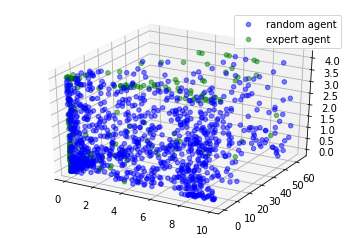

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_random[:1000, 0], features_random[:1000, 1], features_random[:1000, 2], c='b', alpha=0.5, label='random agent')
ax.scatter(features_expert[:1000, 0], features_expert[:1000, 1], features_expert[:1000, 2], c='g', alpha=0.5, label='expert agent')
plt.legend()
plt.show()

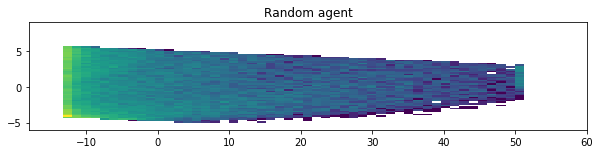

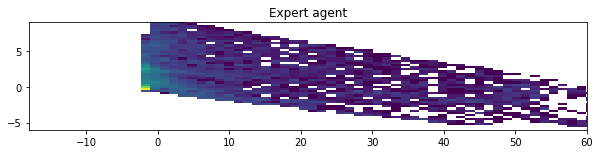

In [9]:
from sklearn.decomposition import PCA
from matplotlib.colors import LogNorm

pca = PCA(n_components=2)
features = np.concatenate((features_expert, features_random))
pca.fit(features)
features_expert_pca = pca.fit_transform(features_expert)
features_random_pca = pca.fit_transform(features_random)

def pca_heatmap(features_pca, title=None):
    heatmap, xedges, yedges = np.histogram2d(features_pca[:, 0], features_pca[:, 1], bins=50)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    plt.figure(figsize=(10, 10))
    plt.clf()
    plt.imshow(heatmap.T, extent=extent, origin='lower', norm=LogNorm())
    plt.xlim([-18, 60])
    plt.ylim([-6, 9])
    if title is not None:
        plt.title(title)
    plt.show()
    
pca_heatmap(features_random_pca, title='Random agent')
pca_heatmap(features_expert_pca, title='Expert agent')

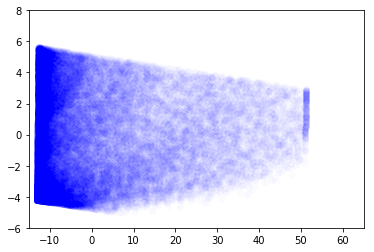

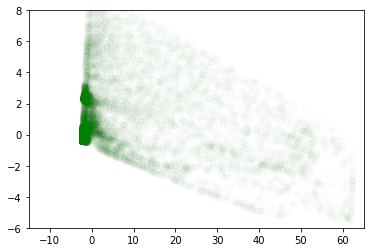

In [10]:
plt.scatter(features_random_pca[:, 0], features_random_pca[:, 1], c='b', alpha=0.01)
plt.xlim([-15, 65])
plt.ylim([-6, 8])
plt.show()
plt.scatter(features_expert_pca[:, 0], features_expert_pca[:, 1], c='g', alpha=0.01)
plt.xlim([-15, 65])
plt.ylim([-6, 8])
plt.show()

In [11]:
mu_expert = np.mean(features_expert, axis=0)
mu_random = np.mean(features_random, axis=0)
print('Mu expert: ' + str(mu_expert))
print('Mu random: ' + str(mu_random))

Mu expert: [0.489 2.23  0.546]
Mu random: [ 4.772 12.985  1.337]


In [12]:
mus = [mu_expert, mu_random]
labels = [1.0, -1.0]

In [13]:
def solve_svm(mus, labels, C=10):
    mus = np.array(mus)
    labels = np.array(labels)
    w = cvx.Variable(mus.shape[1])
    b = cvx.Variable()

    eps = cvx.Variable(labels.shape[0])

    objective   = cvx.Minimize(cvx.norm(w, 2) + C * sum(eps))
    constraints = [cvx.multiply(labels, (mus * w + b)) >= 1 - eps, \
                   eps >= 0]

    problem = cvx.Problem(objective, constraints)
    problem.solve()

    yResult =  mus.dot(w.value) + b.value
    supportVectorRows = np.where(np.isclose(np.abs(yResult), 1))[0]

    print('Problem status: ' + str(problem.status))
    print('Reward coefficients: ' + str(w.value))
    print('Reward bias: ' + str(b.value))
    print('Distance: ' + str(2/problem.value))
    print('The support vectors are mus number ' + str(supportVectorRows))
    print('(index 0 is expert demonstration, 1 random demonstration, higher: intermediate mus)')
    
    return w.value, b.value

solve_svm(mus, labels);

Problem status: optimal
Reward coefficients: [-0.064 -0.16  -0.012]
Reward bias: 1.3938745578719278
Distance: 11.60281216831411
The support vectors are mus number [0 1]
(index 0 is expert demonstration, 1 random demonstration, higher: intermediate mus)


In [14]:
class PendulumRewardWrapper(gym.Wrapper):
    
    def __init__(self, env):
        super(PendulumRewardWrapper, self).__init__(env)
        self.weights = None
    
    def reset(self):
        return self.env.reset()
    
    def step(self, action):
        # execute action
        next_state, reward, terminated, info = self.env.step(action)
        
        assert 'features' in info.keys(), "PendulumRewardWrapper needs to be wrapped around a PendulumFeatureWrapper"
        assert self.weights is not None
        
        info['true_reward'] = reward
        reward = np.dot(info['features'], self.weights) + self.bias
        
        return next_state, reward, terminated, info

    
    def set_reward_coefficients(self, weights, bias):
        self.weights = weights
        self.bias = bias

In [15]:
for i in range(100):
    print('- ' * 10)
    print('ITERATION ' + str(i + 1))
    reward_coefficients, reward_bias = solve_svm(mus, labels)
        
    with tf.Session(graph=tf.Graph()):
        
        model_current, env = train_model(5e6, 0, reward_coefficients=reward_coefficients, reward_bias=reward_bias)
        
        env = env.envs[0]
        print('Collecting trajectories..')
        features_current, mean_rew_current = get_traj_features(200, model_current)
        print('Achieved mean true reward: ' + str(mean_rew_current))
        
        mu_current = np.mean(features_current, axis=0)
        print('Current mu: ' +str(mu_current))
        mus.append(mu_current)
        labels.append(-1.0)


- - - - - - - - - - 
ITERATION 1
Problem status: optimal
Reward coefficients: [-0.064 -0.16  -0.012]
Reward bias: 1.3938745578719278
Distance: 11.60281216831411
The support vectors are mus number [0 1]
(index 0 is expert demonstration, 1 random demonstration, higher: intermediate mus)
env_type: classic_control
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Training trpo_mpi on classic_control:Pendulum-v0 with arguments 
{'network': 'mlp'}
-111.82302
117.24097
134.73706
139.07504
139.53857
138.91524
142.72682
142.71782
143.10815
143.77242
145.03075
149.65694
160.92264
151.2888
153.5928
157.68817
155.51146
153.84941
155.80307
155.41675
161.17825
149.31319
153.15897
155.42938
154.39552
160.16937
159.71739
158.82068
159.30736
149.92133
157.19614
156.0024
155.91525
152.26108
150.39862
150.44771
159.53848
155.71909
153.63397
148.35782
150.9409

KeyboardInterrupt: 

In [16]:
print(np.array(mus))

[[4.890e-01 2.230e+00 5.464e-01]
 [4.772e+00 1.298e+01 1.337e+00]
 [7.951e+00 5.153e-01 8.903e-01]
 [6.278e-01 2.179e+00 2.301e+00]
 [3.117e+00 1.583e+01 6.004e-02]
 [7.393e+00 3.506e+00 9.029e-02]
 [6.476e+00 9.694e+00 3.540e-01]
 [6.637e+00 5.634e+00 6.854e-02]
 [4.746e+00 1.191e+01 4.430e-02]
 [2.061e+00 2.906e+00 2.287e-01]
 [5.493e-01 2.002e+00 3.174e-01]
 [3.088e+00 4.822e+01 3.451e+00]]


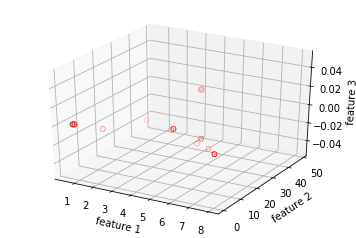

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X = np.array(mus)
plt.scatter(X[0, 0], X[0, 1], X[0, 2], c='g', lw=5)
plt.scatter(X[1:, 0], X[1:, 1], X[1:, 2], c='r', lw=5)
# ax.set_xlim(0, 8)
# ax.set_ylim(0, 14)
# ax.set_zlim(-0.05, 0.01)
plt.xlabel('feature 1')
plt.ylabel('feature 2')
ax.set_zlabel('feature 3')
plt.show()

In [18]:
reward_coefficients ** 1

array([-1.197e-07,  5.816e-09,  3.552e-09])

In [19]:
def plotSvmResult(X, y, curves, SV=None, margins=False):
    nRows = np.where(np.less(y, 0))[0]
    pRows = np.where(np.greater(y, 0))[0]
    nX = X[nRows, :]
    pX = X[pRows, :]
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    # plot the data points according to their class:
    ax1.scatter(nX[:, 0], nX[:, 1], s=20, color='r', marker="s", label='-1')
    ax1.scatter(pX[:, 0], pX[:, 1], s=20, color='g', marker="o", label='1')
    if SV is not None:
        # plot the support vectors:
        nSV = np.intersect1d(SV, nRows)
        ax1.scatter(X[nSV, 0], X[nSV, 1], s=20, color='y', marker="s", label='-1 sv')
        pSV = np.intersect1d(SV, pRows)
        ax1.scatter(X[pSV, 0], X[pSV, 1], s=20, color='y', marker="o", label='1 sv')
    for curve in curves:
    # plot the hyperplane
    # a*x + b = 0 <=> x2 = (-a1/a2)x1 - b/a2
        slope = -curve[0].value[0]/curve[0].value[1]
        x1s = np.array([0, 10])
        x2s = np.multiply(x1s, slope)
        x2s = x2s + -curve[1].value/curve[0].value[1]
#         x2s = np.add(x2s, -curve[1].value/curve[0].value[1]).tolist()[0]
        plt.plot(x1s, x2s, c=curve[3], label=curve[2])
        if margins:
            # plot the margins of the hyperplane:
            x2sL = x2s +  1.0/curve[0].value[1]
            plt.plot(x1s, x2sL, c = curve[3], ls='dashed', lw=0.5)
            x2sU = x2s + -1.0/curve[0].value[1]
            plt.plot(x1s, x2sU, c = curve[3], ls='dashed', lw=0.5)    
#     plt.legend(loc='upper left', ncol=2);
    ax1.set_xlabel('x1')
    ax1.set_ylabel('x2')
#     plt.xlim([-12, 35])
    plt.ylim([-30, 30])
    plt.show()

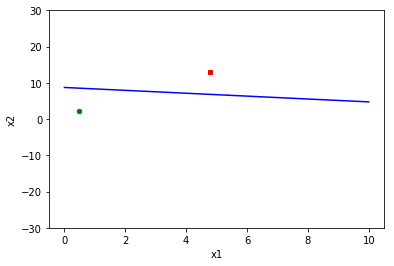

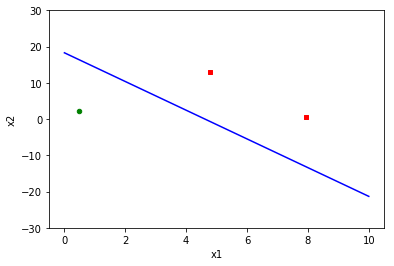

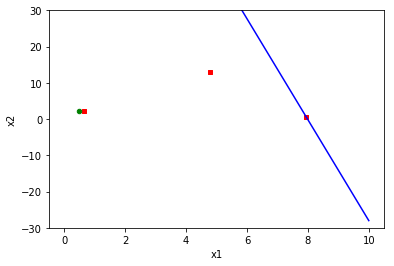

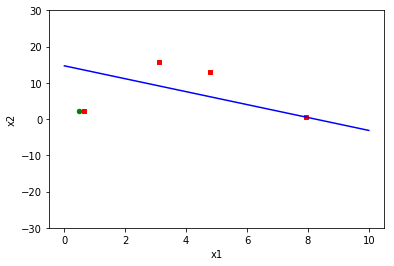

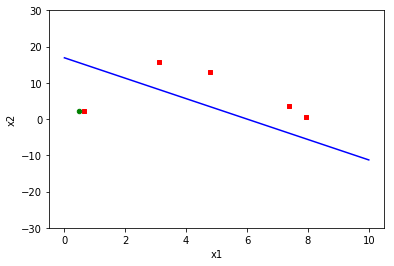

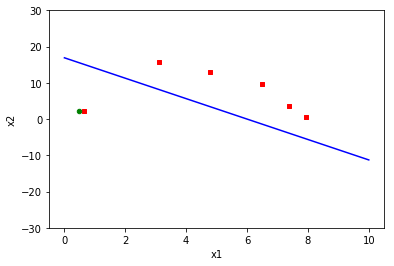

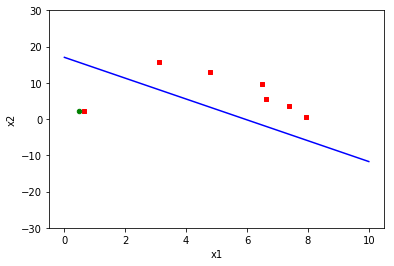

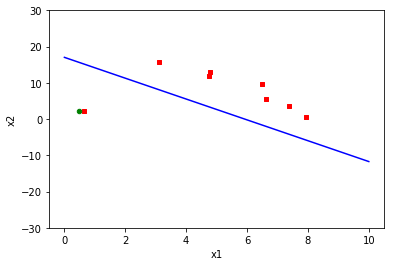

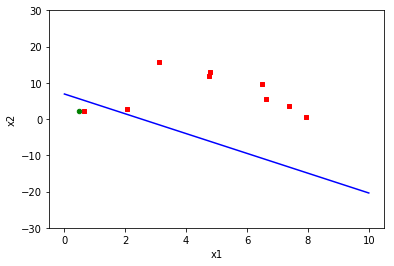

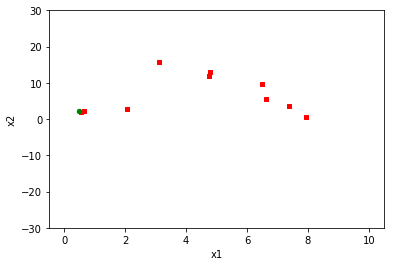

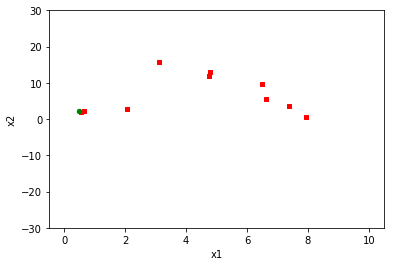

In [43]:
for i in range(len(mus) - 1):
    X = np.array(mus[:2+i])
    y = np.array(labels[:2+i])
    w = cvx.Variable(X.shape[1])
    b = cvx.Variable()

    eps = cvx.Variable(y.shape[0])

    objective   = cvx.Minimize(cvx.norm(w, 2) + 1 * sum(eps))
    constraints = [cvx.multiply(y, (X * w + b)) >= 1 - eps, \
                   eps >= 0]

    problem = cvx.Problem(objective, constraints)
    problem.solve()
    plotSvmResult(X, y, [(w, b, '', 'b')], margins=False)
    

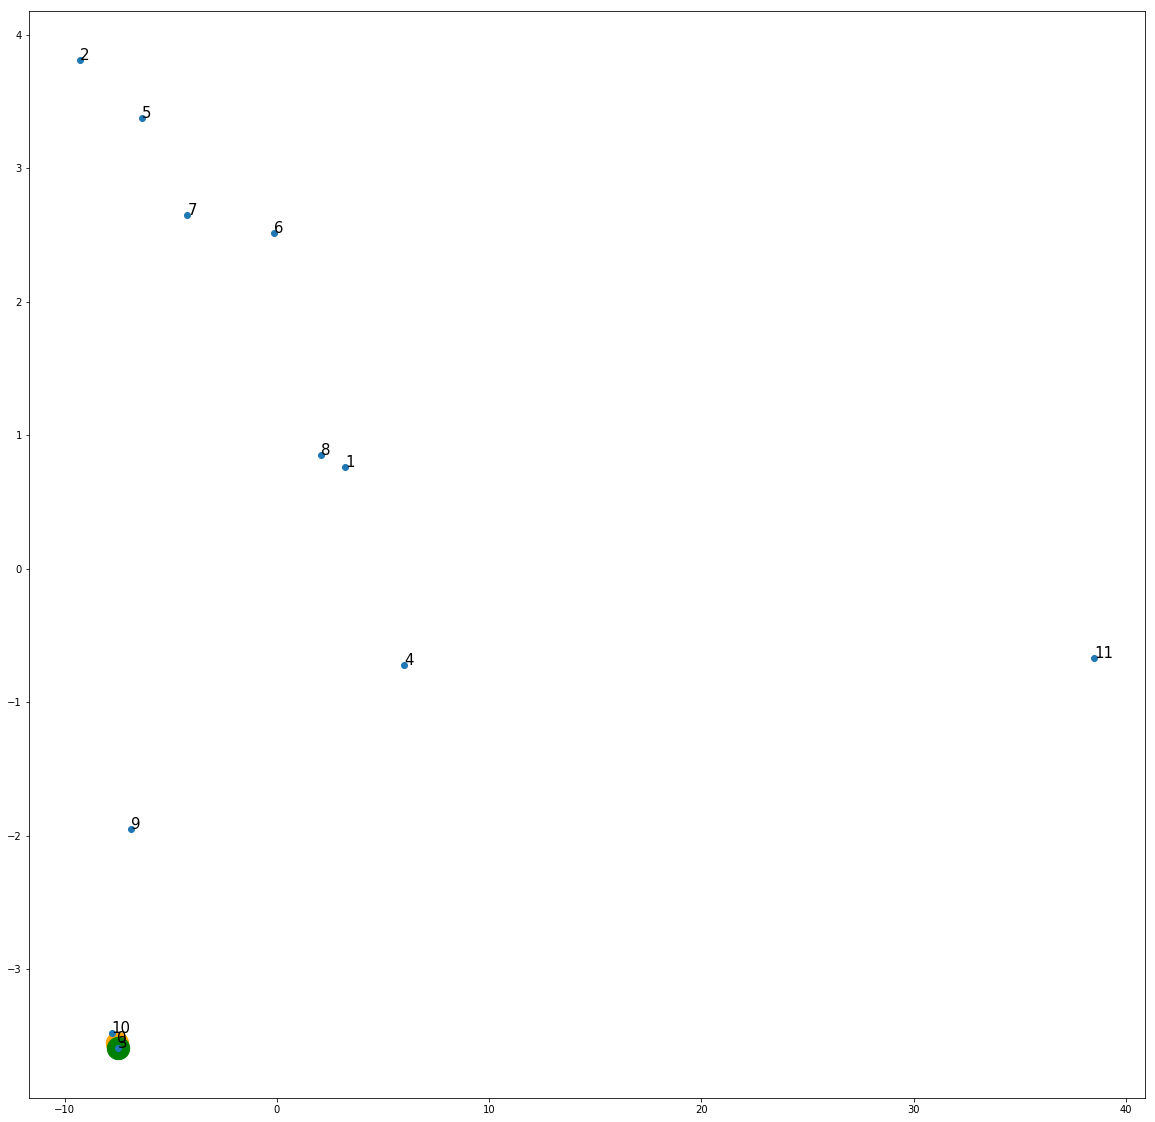

In [50]:
pcaX = pca.fit_transform(mus)
# plt.figure()
fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(pcaX[0, 0], pcaX[0, 1], c='orange', s=500)
ax.scatter(pcaX[3, 0], pcaX[3, 1], c='green', s=500)
ax.scatter(pcaX[1:, 0], pcaX[1:, 1])
for i in range(len(mus)):
    ax.annotate(i, (pcaX[i, 0], pcaX[i, 1]), size=15)
plt.show()

In [28]:
print(np.round(np.array(mus), 1))

[[ 0.5  2.2  0.5]
 [ 4.8 13.   1.3]
 [ 8.   0.5  0.9]
 [ 0.6  2.2  2.3]
 [ 3.1 15.8  0.1]
 [ 7.4  3.5  0.1]
 [ 6.5  9.7  0.4]
 [ 6.6  5.6  0.1]
 [ 4.7 11.9  0. ]
 [ 2.1  2.9  0.2]
 [ 0.5  2.   0.3]
 [ 3.1 48.2  3.5]]
